# Data Preprocessing: Constructing Meaningful Acoustic Representations

In this series of notebooks, we will explore different options for representing acoustic signals. This is an important consideration when constructing a machine learning (ML) pipeline, since we want to provide our networks with inputs that are as meaningful as possible. As we proceed through the various techniques used to analyze acoustic signals, we will make use of the Orchive orca bioacoustics dataset, which we have uploaded to and stored in a Google API bucket [here](https://storage.googleapis.com/ml-bioacoustics-datasets/orchive-dataset.tar.gz). In particular, we will focus on a single call type that serves as a prototypical example of a tonal bioacoustic signal. We will also use a recording from the [Watkins Marine Mammal Sound Database](https://cis.whoi.edu/science/B/whalesounds/index.cfm) containing a sperm whale coda, which is comprised of transient broadband clicks. For clarification, we'll append ``_orca`` and ``_sw`` to the orca and sperm whale variables defined in these notebooks.

Let's get started with loading the data.

## Loading the Data

We'll begin with a few usual imports, and we'll employ fastai's ``untar_data`` method to access the Orchive dataset.

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

from fastai.vision.all import *

np.random.seed(42)

In [5]:
path = untar_data('https://storage.googleapis.com/ml-bioacoustics-datasets/orchive-dataset.tar.gz')

Great! We've loaded the path and confirmed that it contains the appropriate directories. Next, we'll dive into the directory 'call-catalog-xsilence', which contains signals that have been processed to remove leading and tailing silences, allowing us to focus expressly on the call type contained in the sample. Furthermore, for this initial data_preprocessing, let's take a look at a single call type. For simplicity, we'll look at a N01 call.

In [7]:
call_path = Path('../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01')
file_path = call_path.ls()[0]
file_path

Path('../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff')

Ok, now that we've extracted a single path to a single .aiff file, let's inspect this file. We can start off by defining a ``Labelling`` class to generate a suite of labels for the signal.

In [8]:
class Labelling(object):
    
    def __init__(self, path):
        self.path=path
        
    def get_path_name(self):
        return str(self.path)
    
    def get_aiff_name(self):
        path_name = self.get_path_name()
        return path_name.split('/')[-1]
    
    def gen_label(self):
        aiff_name = self.get_aiff_name()
        label = aiff_name.split('-')[0] + '-' + aiff_name.split('-')[1]
        return label
    
    def get_matriline(self):
        label = self.gen_label()
        return label.split('-')[0]
    
    def get_call_type(self):
        label = self.gen_label()
        return label.split('-')[1]
        
    
labeller = Labelling(file_path)
print(f'Original Path: {labeller.get_path_name()}')
print(f'File Name: {labeller.get_aiff_name()}')
print(f'Signal Label: {labeller.gen_label()}')
print(f'Matriline: {labeller.get_matriline()}')
print(f'Call Type: {labeller.get_call_type()}')

Original Path: ../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff
File Name: A36-N01-062802-D004-12218.aiff
Signal Label: A36-N01
Matriline: A36
Call Type: N01


As shown using the above print statements, the ``Labelling`` class contains objects to get the path to the .aiff file, the name of the .aiff file, the appropropriate label for the signal, and the matriline and call type of the signal. Now that we have labels, let's inspect the audio. Firstly, it's often helpful to hear the audio so that we can build a connection to the animals we are working with! Let's hear what an N01 call sounds like.

In [9]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data_orca, sample_rate_orca = sf.read(path_name)
Audio(data_orca, rate=sample_rate_orca)

Wow! How cool is that?! When working with bioacoustic data, it's always important to remember that the computational we develop can help us develop better conservation and management strategies in order to protect these incredible animals!

Now let's turn to the sperm whale data. We'll load the coda and manually extract a single click. Let's start off by using the ``soundfile`` module to read our wavfile signal. In this case, we'll focus our attention on a single transient broadband sperm whale click. The raw audio file can be found under the 'Best Of' cuts in the [Watkins Marine Mammal Sound Database](https://cis.whoi.edu/science/B/whalesounds/index.cfm).

In [27]:
file = 'data/WatkinsPMacro.wav'
data_sw, sample_rate_sw = sf.read(file)
Audio(data_sw, rate=sample_rate_sw)

Really cool! But for the purposes of this toolbox, we'll focus on a single click in the coda:

In [28]:
click_sw = data_sw[31000:37500]
Audio(click_sw, rate=sample_rate_sw)

Great! Our data is loaded and ready to go! We can now move on with investigating techniques to represent the signal and to preprocess the signal for ML-based analyses.

## Time and Frequency Space Representations

When carrying out audio signal processing using acoustic data, there is an extensive array of options for exploring various representations of the signal. For example, common representations include the naive time space representation, the Fourier transformed frequency space representation, as well as an FFT spectrogram-based time-frequency space representation, but there are many other possibilities in addition to more nuanced possibilities within these common representations. Let's start off with the straightforward time-space and frequency-space representations.

Here, we will plot the original signal in both the time and frequency domains. To carry out the Fourier transform, we will use the ``fft`` method in the ``scipy.fft`` module. Here, we are employing a mathematical technique called a discrete Fourier transform (DFT) to convert from the time domain to the frequency domain, and we make use of the fast Fourier transform (FFT) algorithm to compute the transform quickly and efficiently.

In [29]:
from scipy.fft import fft

In [41]:
def plot_t_and_f_reps(signal, fs, lw=0.1, fmax=6e3):
    N = len(signal)
    delta_t = 1 / fs
    times = np.arange(0, N) / fs
    signalf = fft(signal)
    freqs = np.linspace(0.0, 1.0/(2.0*delta_t), N//2)
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    axs[0].plot(times, signal, linewidth=lw)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Time Domain Representation')
    
    axs[1].plot(freqs, 2.0/N * np.abs(signalf[0:N//2]), linewidth=0.4)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('Frequency Domain Representation')
    axs[1].set_xlim([0, fmax])
    
    plt.show()

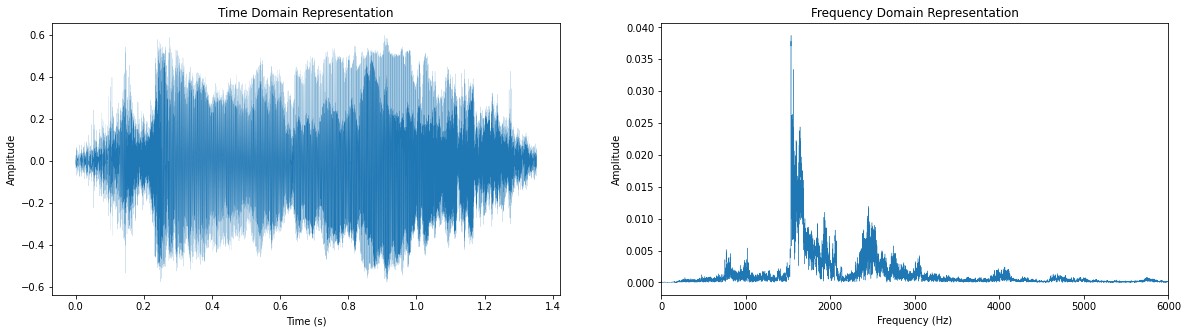

In [42]:
plot_t_and_f_reps(data_orca, sample_rate_orca)

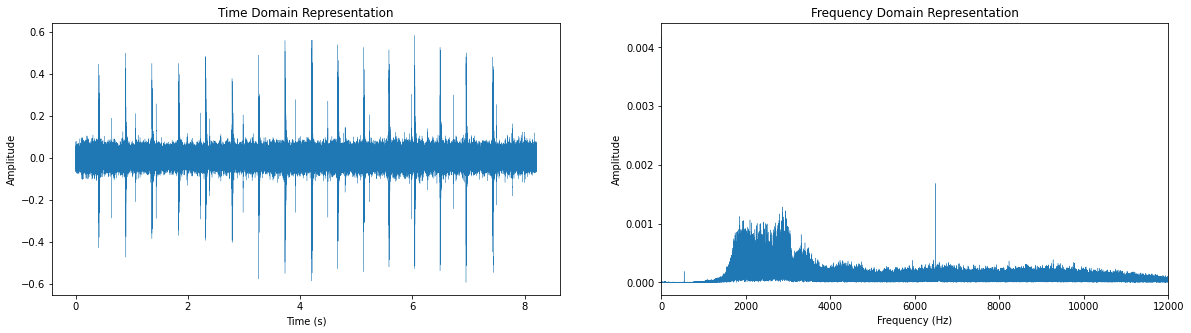

In [47]:
plot_t_and_f_reps(data_sw, sample_rate_sw, lw=0.3, fmax=1.2e4)

Zooming in on a single click yields:

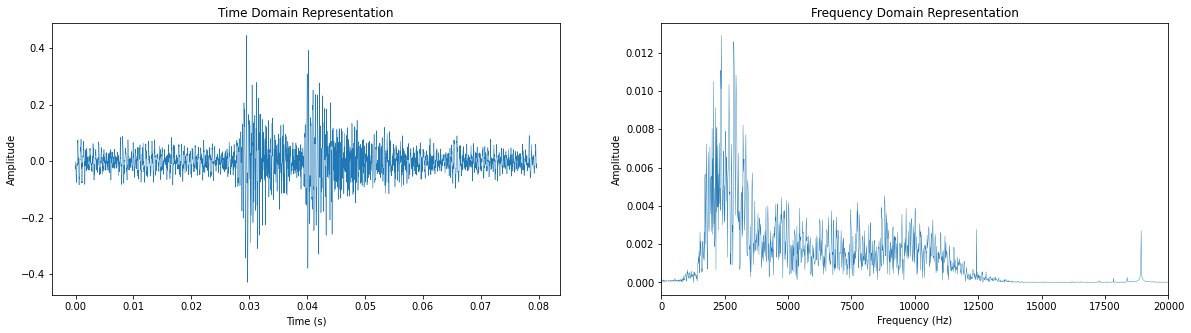

In [45]:
plot_t_and_f_reps(data_sw[31000:37500], sample_rate_sw, lw=0.5, fmax=2e4)

Visually, the above representations immediately seem inadequate. It's challennging to extract any meaningful information purely from the time-varying amplitude, and the frequency space representation entirely omits temporal information. With that in mind, we turn our attention towards other representations. In the following notebook, we'll look at the spectrogram, which offers a time-frequency space representation of a signal.